In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from itertools import product

# Прогнозирование уровня средней заработной платы в России

In [2]:
ds = pd.read_csv("WAG_C_M.csv", delimiter=";", dayfirst=True, parse_dates=["month"], index_col="month")
ds.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


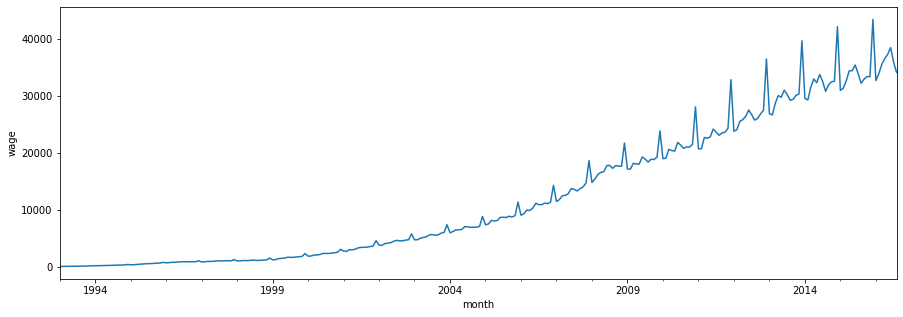

In [3]:
ds = ds.rename(columns={"WAG_C_M":"wage"})
plt.figure(figsize=(15, 5))
ds.wage.plot()
plt.ylabel("wage")
plt.show()

## 1. Визуальный анализ ряда

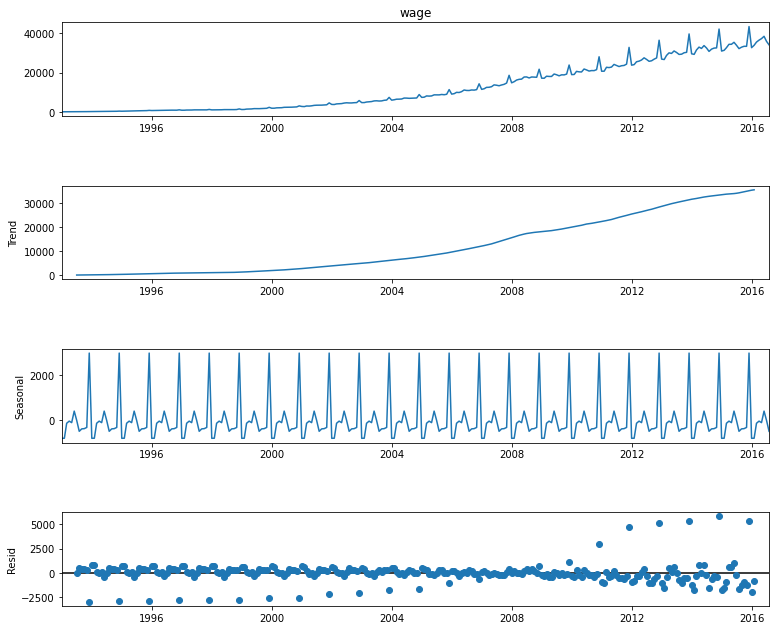

In [4]:
fig = sm.tsa.seasonal_decompose(ds.wage).plot()
fig.set_size_inches(12, 10)
plt.show()

In [5]:
print("Критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(ds.wage)[1])

Критерий Дики-Фуллера: p = 0.9918495954854735


**Тренд - повышающийся**

**Сезонные колебания есть, период - 12 месяцев.**

**Цикличность не заметна**

**Остатки не стационарные**

**Дисперсия не стабильная**

## 2. Стабилизация дисперсии
Для стабилизации дисперсии будет использовано преобразование Бокса-Кокса

In [6]:
ds["wage_box"], box_lambda = stats.boxcox(ds.wage)
print("Box-Cox lambda =", box_lambda)

Box-Cox lambda = 0.2632017541844584


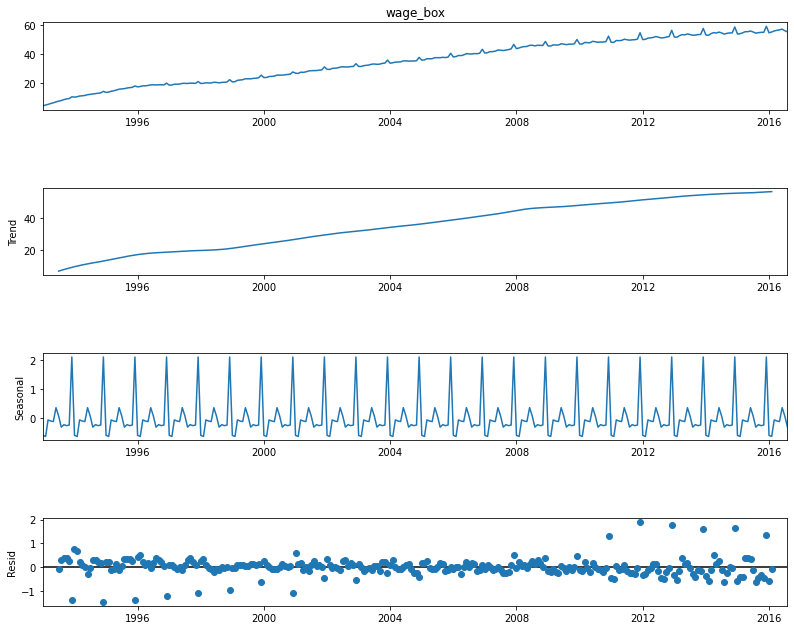

In [7]:
fig = sm.tsa.seasonal_decompose(ds.wage_box, period=12).plot()
fig.set_size_inches(12, 10)

In [8]:
print("Критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(ds.wage_box)[1])

Критерий Дики-Фуллера: p = 0.6968987634832757


**Тренд - повышающийся**

**Сезонные колебания есть, период - 12 месяцев.**

**Цикличность не заметна**

**Остатки не стационарные**

**Дисперсия не стабильная**

## 3. Дифференцирование ряда

### 3.1 Сезонное дифференцирование

In [9]:
wage_box_d_season = (ds.wage_box - ds.wage_box.shift(12)).dropna()
print("Критерий Дики-Фуллера: p =", sm.tsa.stattools.adfuller(wage_box_d_season)[1])

Критерий Дики-Фуллера: p = 0.014697133494791808


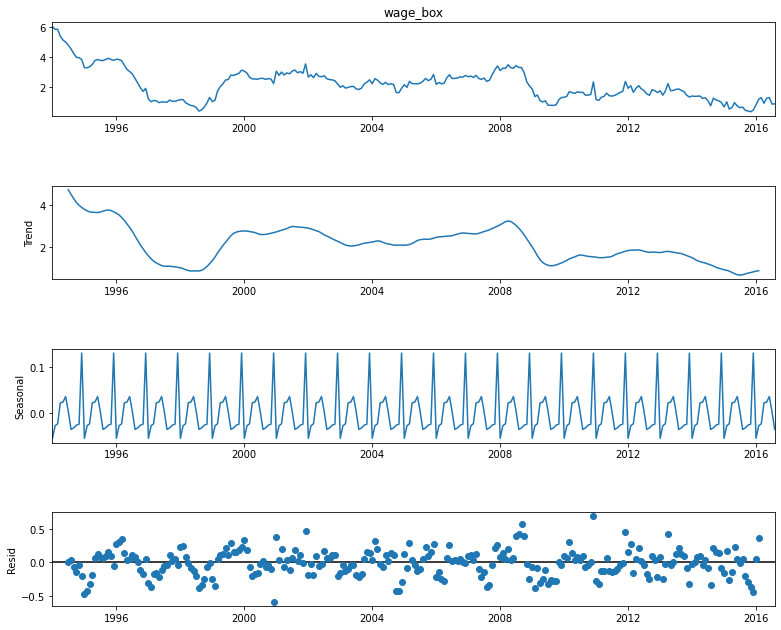

In [10]:
fig = sm.tsa.seasonal_decompose(wage_box_d_season).plot()
fig.set_size_inches(12, 10)

**Критерий Дики-Фуллера отвергает гипотезу о нестационарности, но по-прежнему виден тренд**

### 3.2 Дифференцирование по времени

In [11]:
wage_box_d_season_month = (wage_box_d_season - wage_box_d_season.shift(1)).dropna()
print("Критерий Дики-Фуллера: p =", sm.tsa.adfuller(wage_box_d_season_month)[1])

Критерий Дики-Фуллера: p = 5.2036037158213736e-08


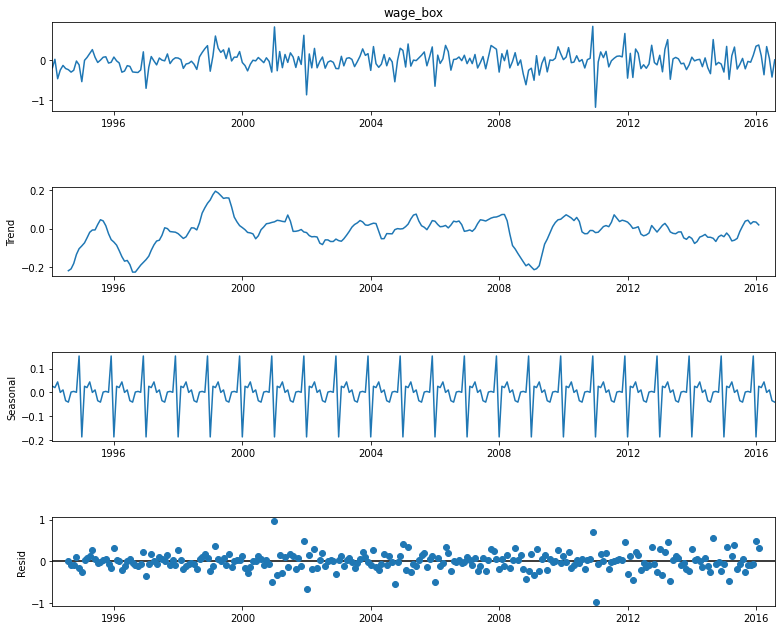

In [12]:
fig = sm.tsa.seasonal_decompose(wage_box_d_season_month).plot()
fig.set_size_inches(12, 10)

**Критерий Дики-Фуллера уверенно отвергает гипотезу о нестационарности ряда**

**Тренд не наблюдается**

## 4. Выбор начальных приближений для p, q, P, Q

/home/as/PycharmProjects/SF/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


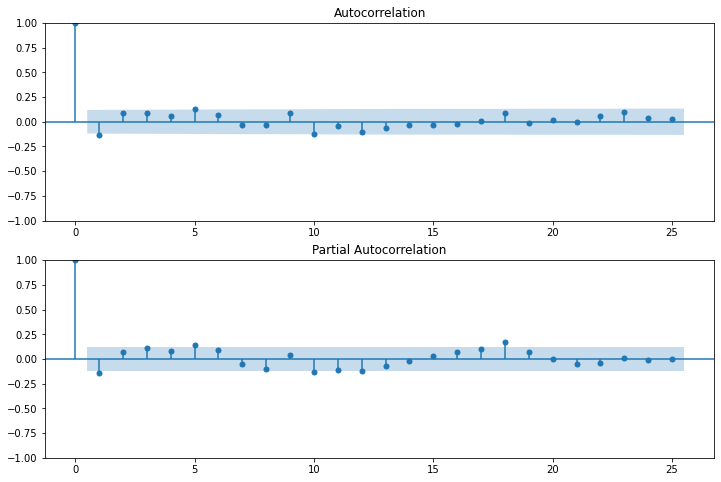

In [13]:
plt.figure(figsize=(12, 8))

ax = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(wage_box_d_season_month, ax=ax)

ax = plt.subplot(212)

fig = sm.graphics.tsa.plot_pacf(wage_box_d_season_month, ax=ax)

In [14]:
P = 1
p = 5
Q = 0
q = 1

## 5. Выбор модели

In [15]:
ps = range(0, p + 1)
qs = range(0, q + 1)
d = 1
Ps = range(0, P + 1)
Qs = range(0, Q + 1)
D = 1
parameters = list(product(ps, qs, Ps, Qs))

In [16]:
%%time

results = []
best_aic = float("Inf")

ds.index = pd.DatetimeIndex(ds.index, freq=ds.index.inferred_freq)
for p in parameters:
    try:
        model = sm.tsa.statespace.SARIMAX(ds.wage_box, order=(p[0], d, p[1]), seasonal_order=(p[2], D, p[3], 12)).fit(disp=-1)
        if model.aic < best_aic:
            best_model = model
            best_aic = model.aic
        results.append([p, model.aic])
    except:
        print("Wrong parameters:", p)

/home/as/PycharmProjects/SF/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/as/PycharmProjects/SF/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/as/PycharmProjects/SF/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/as/PycharmProjects/SF/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-

CPU times: user 28.9 s, sys: 1min 3s, total: 1min 31s
Wall time: 7.29 s


In [17]:
ds_results = pd.DataFrame(results, columns=["Parameters", "AIC"])
ds_results.sort_values(by="AIC").head()

,Parameters,AIC
23,"(5, 1, 1, 0)",-5.260134
15,"(3, 1, 1, 0)",-4.995859
21,"(5, 0, 1, 0)",-4.545935
19,"(4, 1, 1, 0)",-3.975974
11,"(2, 1, 1, 0)",-3.884138


In [18]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            wage_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 1)x(1, 1, [], 12)   Log Likelihood                  10.630
Date:                             Tue, 26 Oct 2021   AIC                             -5.260
Time:                                     22:02:15   BIC                             23.557
Sample:                                 01-01-1993   HQIC                             6.310
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2017      0.436      0.462      0.644      -0.653       1.057
ar.L2          0.0993      

## 6. Анализ остатков

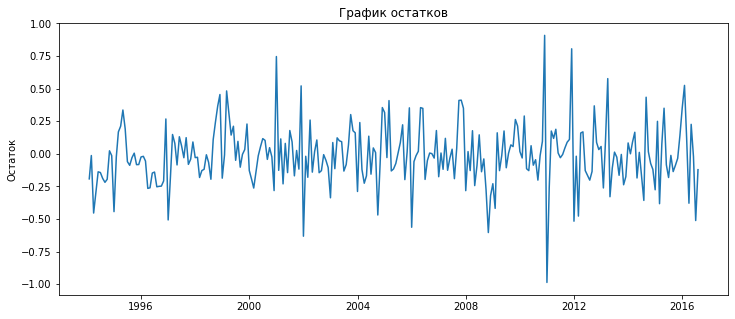

In [19]:
resids = best_model.resid[13:]
plt.figure(figsize=(12, 5))
plt.plot(ds.index[13:], resids)
plt.ylabel("Остаток")
plt.title("График остатков")
plt.show()

### 6.1 Несмещённость относительно нуля

In [20]:
print("Среднее значение остатков: ", resids.mean())
print("H0 - среднее значение остатков равно 0. Тест Стьюдента, p-values = ", stats.ttest_1samp(resids, 0)[1])

Среднее значение остатков:  -0.014792680415533282
H0 - среднее значение остатков равно 0. Тест Стьюдента, p-values =  0.29616718339822373


**Гипотеза о несмешённости остатков относительно нуля не отвергается**

### 6.2 Стационарность

In [21]:
print("H0 - ряд не стационарный. Критерий Дики-Фуллера, p =", sm.tsa.stattools.adfuller(resids)[1])

H0 - ряд не стационарный. Критерий Дики-Фуллера, p = 1.9782195892081633e-29


**Стационарность остатков подтверждается критерием Дики-Фуллера и графиком остатков**

### 6.3 Неавтокоррелированность

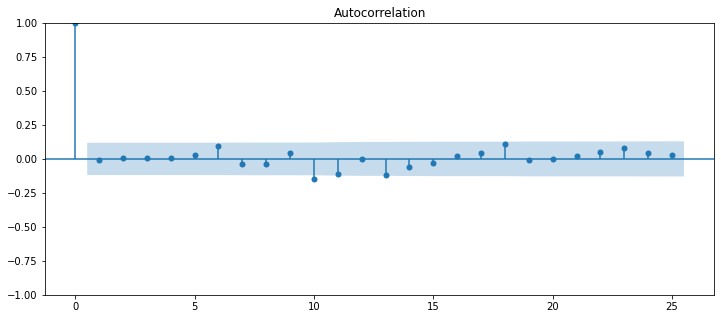

In [22]:
fig = sm.tsa.graphics.plot_acf(resids)
fig.set_size_inches(12, 5)
plt.show()

**Неавтокоррелированность остатков подверждается визуально на ACF**

**Q-тест Льюнг-Бокса даёт достигаемый уровень значимости p = 0.86, т.е. гипотеза о коррелированности остатков отвергается**

## 7. Прогнозирование

### 7.1 Приближение модели

In [23]:
def boxcox_inv(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

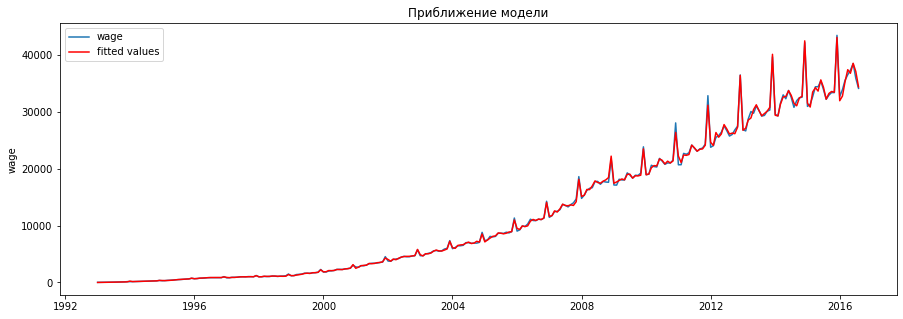

In [24]:
ds["wage_model"] = boxcox_inv(best_model.fittedvalues, box_lambda).values
plt.figure(figsize=(15, 5))
plt.plot(ds.wage, label="wage")
plt.plot(ds.wage_model, color="r", label="fitted values")
plt.title("Приближение модели")
plt.ylabel("wage")
plt.legend()
plt.show()

### 7.2 Построение прогноза

Загрузка данных о реальных средних зарплатах. Исходные данные получены со страницы http://sophist.hse.ru/hse/1/tables/WAG_M.htm

In [25]:
ds_predict = pd.read_csv("wage_2016_2021.csv", delimiter=";", index_col="month", parse_dates=["month"], dayfirst=True)
ds_predict.head()

FileNotFoundError: [Errno 2] No such file or directory: 'wage_2016_2021.csv'

Построение предсказания

In [ ]:
predict_start = len(best_model.fittedvalues)
predict_end = len(best_model.fittedvalues) + ds_predict.shape[0] - 1
ds_predict["wage_predicted"] = boxcox_inv(best_model.predict(predict_start, predict_end), box_lambda).values
ds_predict.head()

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(ds_predict.wage, label="Wage")
plt.plot(ds_predict.wage_predicted, color="r", label="Predicted Wage")
plt.title("Соответствие предсказания реальной зарплате")
plt.ylabel("рубли")
plt.legend()
plt.show()

**С каждым годом график начинает расходится всё сильнее. Величина тренда в модели, рассчитанной для данных на 08.2016, явно недостаточна и требует ежегодной корректировки.**